In [1]:
from src.utils.load_data import load_data, TRAIN_DATA_POINTS, TEST_DATA_POINTS, N_CLASSES
from src.utils.processing import generate_class_matrix, generate_test_class_matrix
from src.utils.augmentation import augment_data

train_data, train_class_matrix = augment_data(
    load_data("data/ae.train", num_data_points=TRAIN_DATA_POINTS)
)
test_data = load_data("data/ae.test", num_data_points=TEST_DATA_POINTS)

test_class_matrix = generate_test_class_matrix(TEST_DATA_POINTS, N_CLASSES)

Successfully created a NumPy array with shape: (270, 29, 12)
Successfully created a NumPy array with shape: (370, 29, 12)


The following code displays a random data point.

Showing data point 0.


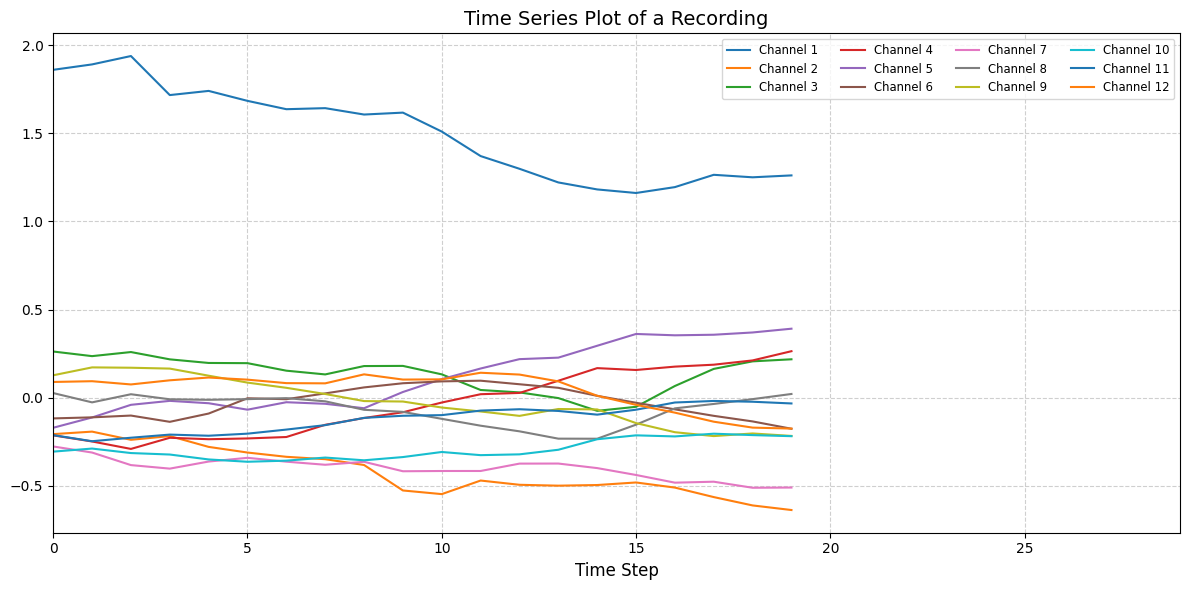

In [2]:
from src.utils.visualize_data import visualize_data_point
import numpy as np

data_idx = np.random.randint(0, TRAIN_DATA_POINTS)

print(f"Showing data point {data_idx}.")
visualize_data_point(train_data[data_idx])

Visualizing the pattern mean of the training data. The tail of the signal is less smooth, because the number of data points that reach that lenght taper off.

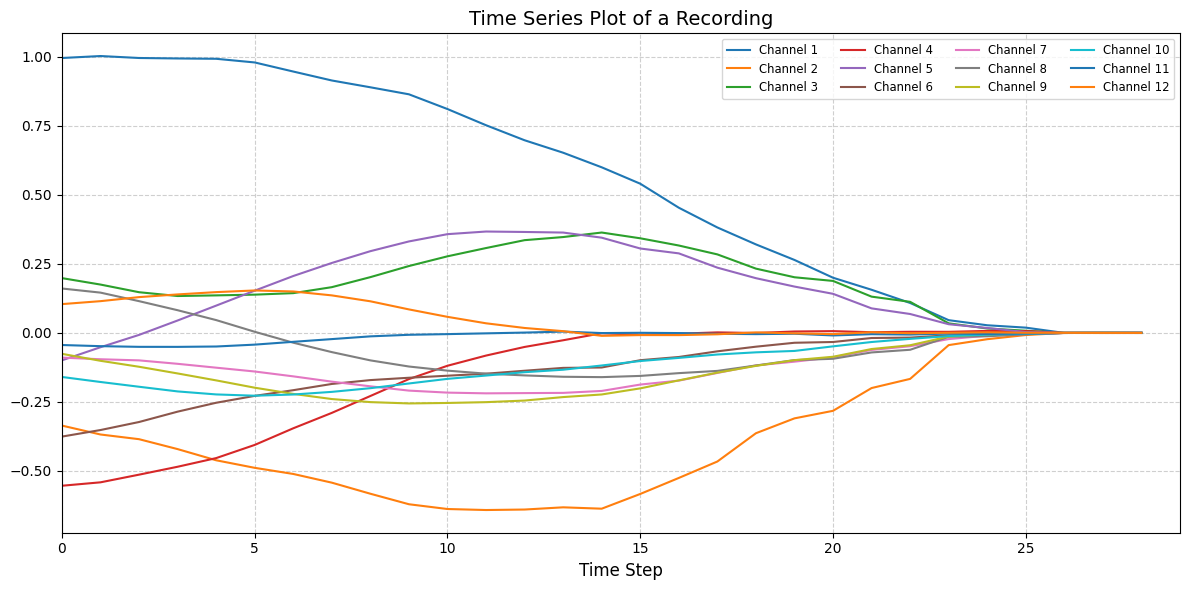

In [3]:
from src.utils.processing import get_pattern_mean

train_pattern_mean = get_pattern_mean(train_data)
visualize_data_point(train_pattern_mean)

The distribution of signal lengths in the training data

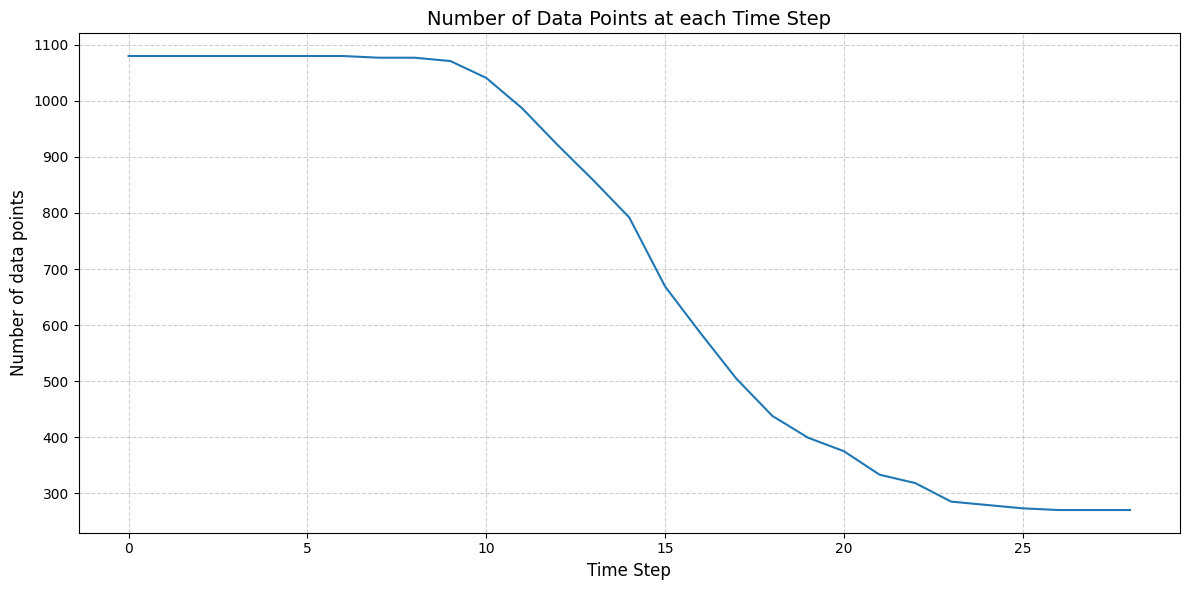

In [4]:
from src.utils.processing import get_time_steps
from src.utils.visualize_data import visualize_data_lengths

time_steps = get_time_steps(train_data)
visualize_data_lengths(time_steps)

Visualizing the pattern means for all classes, to get an insight and feel for the different classes.

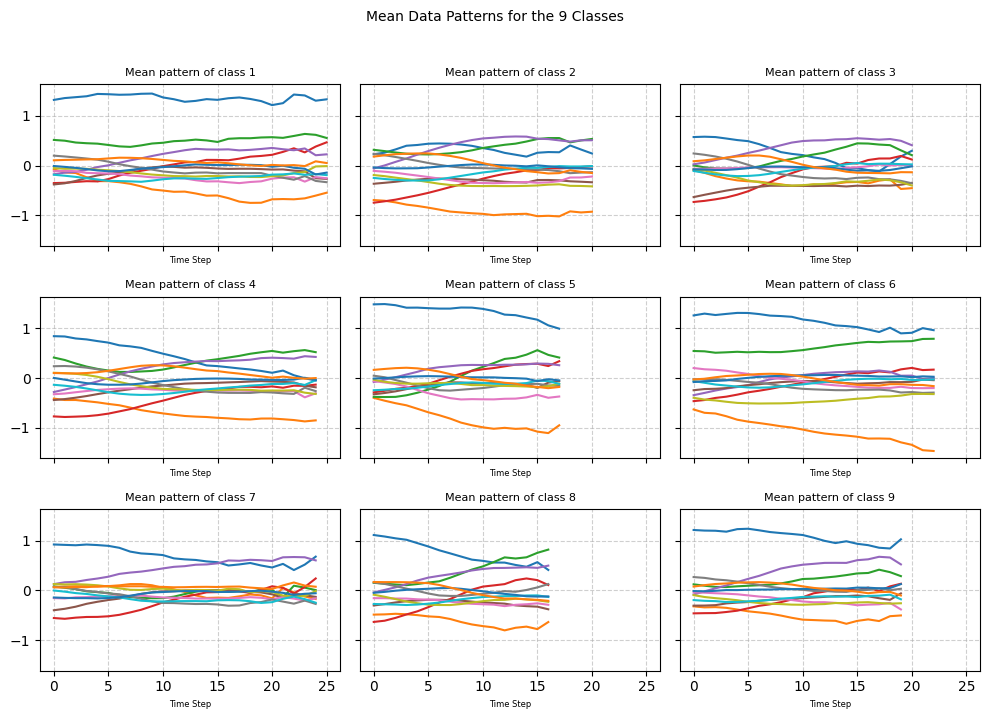

In [5]:
from src.utils.visualize_data import visualize_class_means

visualize_class_means(train_data)

The first step of Principal Component Analysis (PCA) is to obtain the Principal Components (PCs) and the respective feature variances.

In [6]:
from src.utils.pca import normalize, SVD, reduce_PCs, get_feature_vectors

train_data = normalize(train_data, train_pattern_mean)
test_data = normalize(test_data, train_pattern_mean)

principal_components, feature_variances = SVD(train_data)
reduced_PCs = reduce_PCs(feature_variances, principal_components, wanted_variance=99)

train_feature_vectors = get_feature_vectors(train_data, reduced_PCs)
test_feature_vectors = get_feature_vectors(test_data, reduced_PCs)

Here we can see the variance distribution of the PCs. Notice that there are more features than data points. Therefore, the variance after the number of training data points (270) drops to 0.

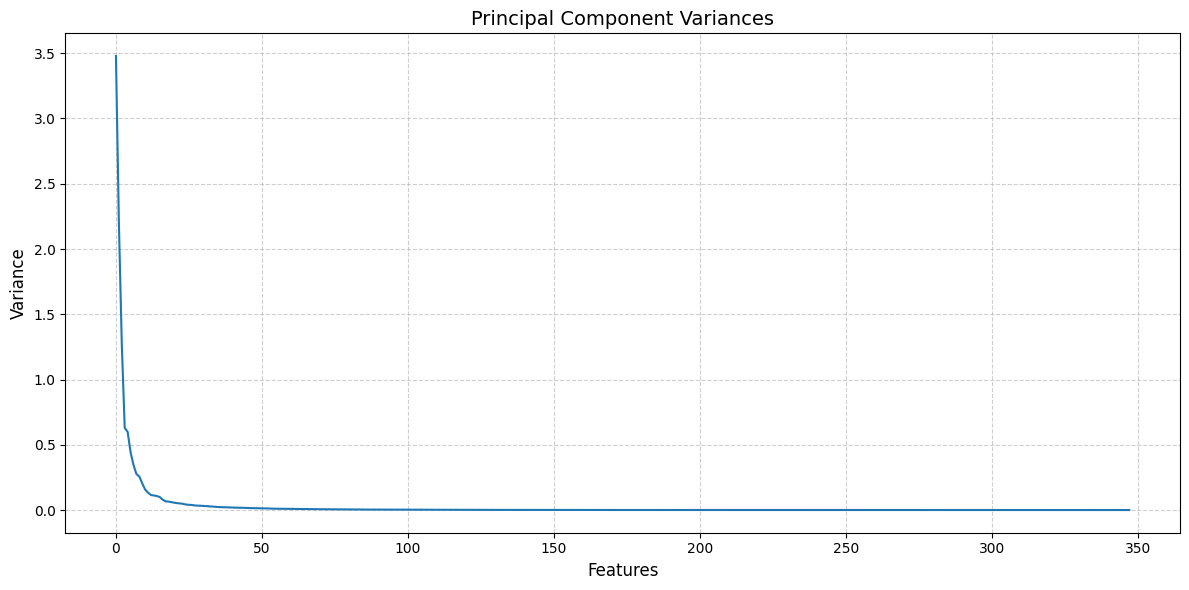

In [7]:
from src.utils.visualize_data import visualize_PC_variance

visualize_PC_variance(feature_variances, log=False)

# Now we run k-fold CVs

In [8]:
from src.utils.k_fold import get_k_folds

folds = get_k_folds(train_feature_vectors, train_class_matrix, k=5)

### Linear regression

In [9]:
from src.linear_regression.classifier import compute_regression_classifier, compute_MSE, compute_mismatch

mses = []
mismatches = []
for x_train, y_train, x_val, y_val in folds:
    reg = compute_regression_classifier(x_train, y_train)

    val_mse = compute_MSE(reg, x_val, y_val)
    val_mismatch = compute_mismatch(reg, x_val, y_val)

    mses.append(val_mse)
    mismatches.append(val_mismatch)

print("Mean MSE: ", np.array(mses).mean())
print("Mean Mismatch: ", np.array(mismatches).mean())

Mean MSE:  21.192274803274536
Mean Mismatch:  0.0


In [10]:
reg = compute_regression_classifier(train_feature_vectors, train_class_matrix)

mse = compute_MSE(reg, test_feature_vectors, test_class_matrix)
mismatch = compute_mismatch(reg, test_feature_vectors, test_class_matrix)

print("Test MSE: ", mse)
print("Test Mismatch: ", mismatch)

Test MSE:  60.29625885430056
Test Mismatch:  0.9162162162162162


# TREE

In [ ]:
from src.random_forest.evaluate import train_and_evaluate_random_forest
import torch

hyperparam_grid = [
    (10, 10),
    (20, 10),
    (20, 20)
]

best_acc = 0
best_params = None

for n_trees, max_depth in hyperparam_grid:
    fold_metrics = []
    accuracies = []

    for x_train, y_train, x_val, y_val in folds:
        X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)

        model, val_accuracy, _ = train_and_evaluate_random_forest(
            X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor,
            n_trees=n_trees,
            max_depth=max_depth
        )

    mean_acc = accuracies.append(val_accuracy)

    if mean_acc > best_acc:
        best_acc = mean_acc
        best_params = (n_trees, max_depth)

print("Best Mean Accuracy: ", best_acc)
print("Best params: ", best_params)


X_train = torch.tensor(train_feature_vectors, dtype=torch.float32)
y_train = torch.tensor(train_class_matrix, dtype=torch.long)
X_test = torch.tensor(test_feature_vectors, dtype=torch.float32)
y_test = torch.tensor(test_class_matrix, dtype=torch.long)

model, test_acc, metrics = train_and_evaluate_random_forest(
    X_train, y_train, X_test, y_test, best_params[0], best_params[1]
)

print("Test Accuracy: ", test_acc)


Mean Accuracy:  0.9787037014961243


We now move on to our k-nearest neighbors (knn) approach

The following block of code is run to perform a hyperparameter search on the number of nearest neighbors.

In [ ]:
from src.knn.knn_pipeline import knn_hyperparameter_search

k_to_search = range(1, 11)
path = "search_results.txt"

# leave-one-out cross validation
knn_hyperparameter_search(
    data=train_data, 
    labels=train_class_matrix, 
    k_to_search=k_to_search, 
    k_folds=TRAIN_DATA_POINTS, 
    results_location=path)

The results of the hyperparameter search for 1 through 10 nearest neighbors are shown by the function in the next block. 
The search is done for two different local distance measures in the Dynamic Time Warping (DTW) procedure. The local distance measures are the absolute distance and the squared distance.

In [ ]:
from utils.visualize_data import show_search_results

show_search_results()

The following code performs the knn classification on the test data and returns the accuracy. It may take a few minutes to run.

In [ ]:
from src.knn.knn_pipeline import knn_accuracy

k_nn = 3
accuracy = knn_accuracy(k_nn, test_data, test_class_matrix, train_data, train_class_matrix)
knn_mismatch = 100 - accuracy
print("Mismatch:\t{:.2f}%".format(knn_mismatch * 100))